Constantes: tamanho do Mock e instância do Faker


In [1]:
from faker import Faker
USER_COUNT = 89068
fake = Faker()

# Funções usadas ao longo do Notebook

Gerar dia válido dentro de um determinado mês. Prioriza primeiros dias.

In [2]:
import numpy as np
import calendar
from scipy.stats import expon

def generate_days(
        month: tuple[int, int],
        size: int,
        start_day: int=1
    ) -> np.ndarray | None:
    _, last_day = calendar.monthrange(*month)
    if start_day == last_day:
        return np.full((size,), start_day)
    elif start_day > last_day:
        return None
    available_days = np.arange(start=start_day, stop=last_day + 1)
    weights = np.copy(available_days)
    weights = weights / np.sum(weights)
    weights = expon.pdf(weights)
    weights = weights / np.sum(weights)
    return np.random.choice(available_days, size=size, p=weights)

# Dados de Usuário


Iremos gerar um DataFrame Pandas para conter informações de usuário, assim como o endereço do mesmo.


In [3]:
import pandas as pd

# Utilizando index do pandas como id
users = pd.DataFrame({
    'created_at': [],
    'birthday': [],
    'city': [],
    'state': [],
    'country': []
})
display(users)

,created_at,birthday,city,state,country


Gerando _created_at_ (omitindo _updated_at_ pois ele não aparece em nenhum lugar do relatório)


Utilizando distribuição ponderada, priorizando os meses 2, 3 e 4.


Primeiro dia: 2023-01-01 00:00:00
Último dia: 2023-06-30 00:00:00


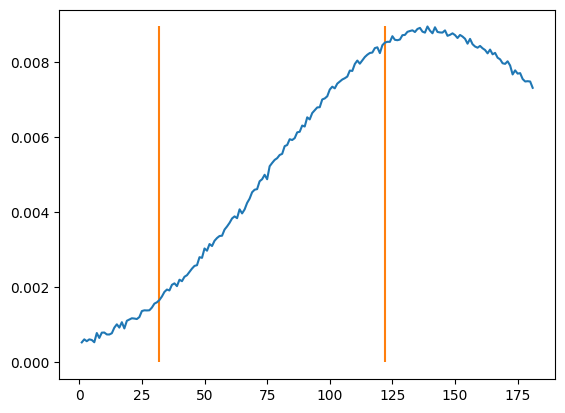

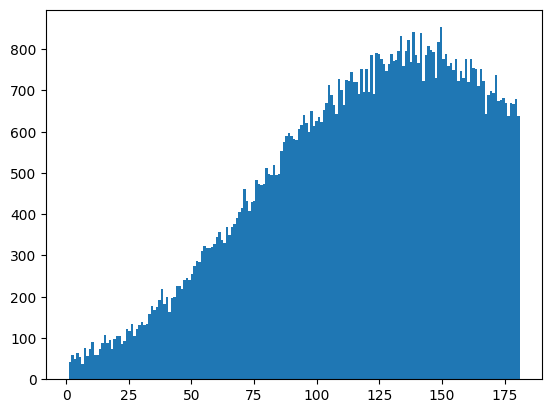

In [4]:
from scipy.stats import skewnorm
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

# Dia 1 -> 01/01/2023
# Dia 2 -> 02/01/2023
# ...
# Dia 181 -> 30/06/2023
# Priorizar meses 2, 3 e 4:
# Mês 1: do dia 1 ao 31
# Mês 2: do dia 32 ao 59
# Mês 3: do dia 60 ao 90
# Mês 4: do dia 91 ao 120
# Mês 5: do dia 121 ao 151
# Mês 6: dia 152 ao 181
# Média: dia 76
# Desvio padrão: 30
# Skewness: 0.5
first_day = 1
last_day = 181
print(f'Primeiro dia: {datetime(2023, 1, 1) + timedelta(days=first_day - 1)}')
print(f'Último dia: {datetime(2023, 1, 1) + timedelta(days=last_day - 1)}')
available_days = np.arange(first_day, last_day + 1)
lin_range = np.linspace(0, 1, last_day - first_day + 1)
weights = skewnorm.pdf(x=lin_range, a=1.5, loc=0.5, scale=0.5)
# Noise
weights = np.abs(weights + np.random.normal(loc=0, scale=0.0075, size=last_day - first_day + 1))
weights = weights / np.sum(weights)
plt.gca().vlines(np.array([32, 122]), ymin=0, ymax=np.max(weights), color='C1')
plt.plot(np.arange(first_day, last_day + 1), weights)
plt.show()

days = np.random.choice(available_days, size=USER_COUNT, p=weights)
plt.hist(days, bins=last_day - first_day + 1)
plt.show()

Horas não são aleatórias: priorizar horários de pico


In [5]:
import numpy as np
from scipy.stats import skewnorm


def gen_random_minutes(size):
    minutes = skewnorm.rvs(a=-0.5, loc=960, scale=240, size=size)
    while True:
        minutes = np.round(minutes, 0).astype(int)
        minutes_outside_interval = np.argwhere(
            (minutes < 0) | (minutes >= 1440)).flatten()
        if (minutes_outside_interval.size == 0):
            break
        minutes[minutes_outside_interval] = skewnorm.rvs(
            a=-0.5, loc=960, scale=240, size=len(minutes_outside_interval))
    return minutes


minutes = gen_random_minutes(USER_COUNT)
hours = minutes // 60
minutes = minutes % 60

Adicionando created_at


In [6]:
from datetime import datetime, timedelta
import numpy as np

def _created_at_gen(day, hour, minute):
    return (datetime(
        2023,
        1,
        1,
        hour,
        minute,
        np.random.randint(0, 60)) + timedelta(days=int(day - 1))).isoformat()
created_at_gen = np.vectorize(_created_at_gen)
created_at = created_at_gen(days, hours, minutes)
users['created_at'] = created_at

Gerando datas de nascimento


Ano será escolhido através de uma distribuição que prioriza fim dos anos 90 e anos 2000


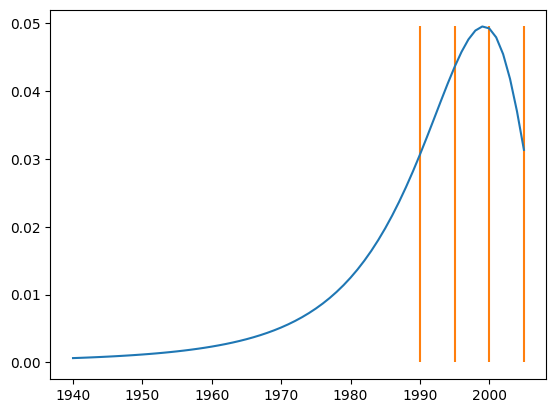

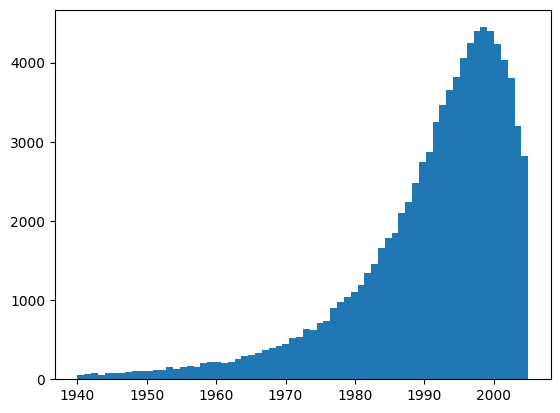

In [7]:
from matplotlib import pyplot as plt
from scipy.stats import alpha

available_years = np.arange(2005, 1939, -1)
lins = np.linspace(0, 1, len(available_years))
weights = alpha.pdf(lins, 3.6, loc=-0.4, scale=2)
weights = weights / np.sum(weights)
plt.gca().vlines([1990, 1995, 2000, 2005], ymin=0, ymax=np.max(weights), color='C1')
plt.plot(available_years, weights)
plt.show()
random_years = np.random.choice(available_years, size=USER_COUNT, p=weights)
plt.hist(random_years, bins=available_years.size)
plt.show()

Mês e dia são completamente randômicos, utiliza distribuição uniforme


In [8]:
random_dates_with_year = np.empty((USER_COUNT,), dtype=object)
for i in range(USER_COUNT):
    year = random_years[i]
    lower_bound = datetime(year, 1, 1)
    upper_bound = datetime(year, 12, 31)
    random_date = fake.date_between(
        start_date=lower_bound, end_date=upper_bound).strftime('%Y-%m-%d')
    random_dates_with_year[i] = random_date
users['birthday'] = random_dates_with_year

Calculando idade para dropar todos os usuários com menos de 18 anos

In [9]:
users['age'] = users['birthday'].apply(lambda bd: (datetime(2023, 7, 27) - datetime.fromisoformat(bd)).days // 365)
users = users[users['age'] >= 18]
users = users.drop(columns='age')
users = users.reset_index(drop=True)
display(users)

,created_at,birthday,city,state,country
0,2023-06-24T17:02:47,1996-04-02,NaN,NaN,NaN
1,2023-03-16T11:48:58,1993-06-29,NaN,NaN,NaN
2,2023-05-28T16:47:36,1981-09-26,NaN,NaN,NaN
3,2023-04-06T16:12:29,1965-04-21,NaN,NaN,NaN
4,2023-02-28T17:13:13,1993-03-01,NaN,NaN,NaN
...,...,...,...,...,...
87825,2023-04-20T11:29:43,1992-03-10,NaN,NaN,NaN
87826,2023-03-31T18:44:56,1997-05-02,NaN,NaN,NaN
87827,2023-06-06T10:41:45,1979-01-15,NaN,NaN,NaN
87828,2023-03-12T17:47:01,1981-04-24,NaN,NaN,NaN


Obtendo índices para cada mês

In [10]:
users['c_at_month'] = users['created_at'].str.slice(start=5, stop=7).apply(lambda str: int(str))
month_intervals = []
for i in range(1, 7):
    idxs = users.index[users['c_at_month'] == i].tolist()
    month_intervals.append(idxs)

# Endereços


Queremos mudar a distribuição de endereços com base na data do onboarding. Portanto, é interessante antes criar uma função que recebe alguns parâmetros, como:

- Importância da população para decidir a cidade
- Presença de cidades fora do Brasil?
- etc


## Cidades do Brasil

Utilizando .csv de municipios contidos [aqui](http://blog.mds.gov.br/redesuas/wp-content/uploads/2018/06/Lista_Munic%C3%ADpios_com_IBGE_Brasil_Versao_CSV.csv)


In [11]:
# Renomeie o CSV
municipios = pd.read_csv('municipios.csv', sep=';')
# Ignorando duas colunas
municipios = municipios.drop(columns=[
    'ConcatUF+Mun',
    'Unnamed: 9']).sort_values(by=['População 2010'], ascending=False)
  # Ignorando munícipios sem informação de população
municipios = municipios.dropna(subset=['População 2010'])
municipios = municipios.reset_index(drop=True)
display(municipios.head(5))
# Transformando Presidente Prudente em uma cidade com 2M de habitantes
# Só pelo lulz
municipios.loc[
    municipios['Município'] == 'Presidente Prudente',
    'População 2010'
  ] = 2000000
display(municipios[municipios['Município'] == 'Presidente Prudente'])

,IBGE,IBGE7,UF,Município,Região,População 2010,Porte,Capital
0,355030,3550308,SP,São Paulo,Região Sudeste,11253503.0,Metrópole,Capital
1,330455,3304557,RJ,Rio de Janeiro,Região Sudeste,6320446.0,Metrópole,Capital
2,292740,2927408,BA,Salvador,Região Nordeste,2675656.0,Metrópole,Capital
3,530010,5300108,DF,Brasília,Região Centro-Oeste,2570160.0,Metrópole,Capital
4,230440,2304400,CE,Fortaleza,Região Nordeste,2452185.0,Metrópole,Capital


,IBGE,IBGE7,UF,Município,Região,População 2010,Porte,Capital
125,354140,3541406,SP,Presidente Prudente,Região Sudeste,2000000.0,Grande,NaN


## Cidades fora do Brasil

Utilizando csv que pode ser encontrado [aqui](https://simplemaps.com/static/data/world-cities/basic/simplemaps_worldcities_basicv1.76.zip)


Países da América Latina


In [12]:
latin_america_countries = [
    'Argentina',
    'Bolivia',
    'Chile',
    'Colombia',
    'Ecuador',
    'Paraguay',
    'Peru',
    'Uruguay'
]

In [13]:
world_cities = pd.read_csv('worldcities.csv')
# Ignorando cidades sem dados populacionais
world_cities = world_cities.dropna(subset=['population'])
# Incluindo apenas cidades da América Latina (exclui Brasil)
world_cities = world_cities[world_cities['country'].isin(latin_america_countries)]
# Excluindo cidades com população menor que 500 mil habitantes
world_cities = world_cities[world_cities['population'] >= 500000]
world_cities = world_cities.reset_index(drop=True)
display(world_cities.head(5))

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Buenos Aires,Buenos Aires,-34.5997,-58.3819,Argentina,AR,ARG,"Buenos Aires, Ciudad Autónoma de",primary,16710000.0,1032717330
1,Lima,Lima,-12.0600,-77.0375,Peru,PE,PER,Lima,primary,10320000.0,1604728603
2,Bogotá,Bogota,4.7111,-74.0722,Colombia,CO,COL,Bogotá,primary,7968095.0,1170483426
3,Santiago,Santiago,-33.4372,-70.6506,Chile,CL,CHL,Región Metropolitana,primary,7171000.0,1152554349
4,Timbío,Timbio,2.3445,-76.6839,Colombia,CO,COL,Cauca,minor,4444444.0,1170815311


Finalmente, preparando a função


In [14]:
def generate_random_cities(size, population_importance=1.6, non_brazilian_percent=0.0):
    brazilian_percent = 1.0 - non_brazilian_percent
    brazilian_size = int(size * brazilian_percent)
    non_brazilian_size = size - brazilian_size
    cities = pd.DataFrame(columns=['city', 'state', 'country'])
    # Cidades brasileiras
    brazilian_cities = pd.DataFrame(columns=['city', 'state', 'country'])
    brazilian_population_power = np.power(
        municipios['População 2010'], population_importance)
    brazilian_population_weights = brazilian_population_power / \
        np.sum(brazilian_population_power)
    brazilian_cities_idx = np.random.choice(
        municipios.index, p=brazilian_population_weights, size=brazilian_size)
    brazilian_cities['city'] = municipios.loc[brazilian_cities_idx,
                                              'Município'].values
    brazilian_cities['state'] = municipios.loc[brazilian_cities_idx, 'UF'].values
    brazilian_cities['country'] = 'Brazil'
    # Cidades não brasileiras
    non_brazilian_cities = pd.DataFrame(columns=['city', 'state', 'country'])
    non_brazilian_population_power = np.power(
        world_cities['population'], population_importance)
    non_brazilian_population_weights = non_brazilian_population_power / \
        np.sum(non_brazilian_population_power)
    non_brazilian_cities_idx = np.random.choice(
        world_cities.index, p=non_brazilian_population_weights, size=non_brazilian_size)
    non_brazilian_cities['city'] = world_cities.loc[non_brazilian_cities_idx, 'city'].values
    non_brazilian_cities['state'] = ''
    non_brazilian_cities['country'] = world_cities.loc[non_brazilian_cities_idx, 'country'].values
    # Concatenando
    cities = pd.concat([brazilian_cities, non_brazilian_cities])
    cities = cities.reset_index(drop=True)
    return cities

Primeiros 2 meses: focar em capitais do Brasil


In [15]:
idxs = month_intervals[0]
idxs.extend(month_intervals[1])
count = len(idxs)
cities = generate_random_cities(count, population_importance=2.5)
users.loc[users.index[idxs], [
    'city', 'state', 'country']] = cities.values

2 próximos meses: cidades brasileiras com menor população


In [16]:
idxs = month_intervals[2]
idxs.extend(month_intervals[3])
count = len(idxs)
cities = generate_random_cities(count, population_importance=1.5)
users.loc[users.index[idxs], [
    'city', 'state', 'country']] = cities.values

2 últimos meses: cidades no exterior


In [17]:
idxs = month_intervals[4]
idxs.extend(month_intervals[5])
count = len(idxs)
cities = generate_random_cities(
    count, population_importance=1.0, non_brazilian_percent=0.05)
users.loc[users.index[idxs], [
    'city', 'state', 'country']] = cities.values

Ordenando DataFrame de forma que created_at seja crescente


In [18]:
users = users.sort_values(by='created_at')
users = users.reset_index(drop=True)
display(users)

,created_at,birthday,city,state,country,c_at_month
0,2023-01-01T07:20:53,1990-11-24,São Paulo,SP,Brazil,1
1,2023-01-01T08:10:19,1998-04-03,São Paulo,SP,Brazil,1
2,2023-01-01T08:44:20,1992-06-28,São Paulo,SP,Brazil,1
3,2023-01-01T08:56:30,1965-03-06,São Paulo,SP,Brazil,1
4,2023-01-01T09:42:52,1989-11-19,Nova Iguaçu,RJ,Brazil,1
...,...,...,...,...,...,...
87825,2023-06-30T22:45:00,1994-02-08,São Paulo,SP,Brazil,6
87826,2023-06-30T22:46:23,2005-07-15,Buriti,MA,Brazil,6
87827,2023-06-30T22:51:57,2001-02-04,Maceió,AL,Brazil,6
87828,2023-06-30T23:12:43,1965-05-21,Cachoeiro de Itapemirim,ES,Brazil,6


Resultado final


In [19]:
display(users['country'].value_counts())
display(users['state'].value_counts())
display(users['city'].value_counts())

country
Brazil       85575
Colombia       667
Argentina      583
Peru           364
Chile          264
Bolivia        203
Ecuador        120
Uruguay         43
Paraguay        11
Name: count, dtype: int64

state
SP    29442
RJ    10303
MG     6566
BA     5031
PR     3571
RS     3516
CE     3291
PE     3047
PA     2497
       2255
GO     2089
MA     1997
SC     1880
DF     1737
AM     1441
PB     1179
ES     1152
RN     1060
AL     1034
PI      986
MT      907
MS      792
SE      643
RO      440
TO      380
AP      229
AC      218
RR      147
Name: count, dtype: int64

city
São Paulo         17936
Rio de Janeiro     6726
Salvador           1893
Brasília           1737
Fortaleza          1612
                  ...  
Lutécia               1
Chiador               1
Vargem Alegre         1
Cerro Branco          1
Eugenópolis           1
Name: count, Length: 4545, dtype: int64

# Salvando dados de usuário em CSV


In [20]:
from datetime import datetime

def age_from_birthday(birthday_str):
    birthday = datetime.fromisoformat(birthday_str)
    difference = datetime(2023, 7, 27) - birthday
    age = difference.days // 365
    return age


users['age'] = users['birthday'].apply(age_from_birthday)
display(users)
users.drop('c_at_month', axis=1).to_csv('users.csv', index_label='id')

,created_at,birthday,city,state,country,c_at_month,age
0,2023-01-01T07:20:53,1990-11-24,São Paulo,SP,Brazil,1,32
1,2023-01-01T08:10:19,1998-04-03,São Paulo,SP,Brazil,1,25
2,2023-01-01T08:44:20,1992-06-28,São Paulo,SP,Brazil,1,31
3,2023-01-01T08:56:30,1965-03-06,São Paulo,SP,Brazil,1,58
4,2023-01-01T09:42:52,1989-11-19,Nova Iguaçu,RJ,Brazil,1,33
...,...,...,...,...,...,...,...
87825,2023-06-30T22:45:00,1994-02-08,São Paulo,SP,Brazil,6,29
87826,2023-06-30T22:46:23,2005-07-15,Buriti,MA,Brazil,6,18
87827,2023-06-30T22:51:57,2001-02-04,Maceió,AL,Brazil,6,22
87828,2023-06-30T23:12:43,1965-05-21,Cachoeiro de Itapemirim,ES,Brazil,6,58


# Transferências


## Função que gera transferências com determinada distribuição de valores e horas


In [32]:
def generate_transfers(
        user_ids,
        transfer_quantity,
        loc=50,
        scale=25,
        num_outliers=0
    ):
    transfers = pd.DataFrame(
        columns=[
            'id_from',
            'id_to',
            'hour',
            'minute',
            'scheduled_date',
            'value',
            'status'
        ]
    )
    ids_from, ids_to = user_ids
    total_size = transfer_quantity
    values = np.random.normal(
        loc=loc,
        scale=scale,
        size=total_size - num_outliers
    )
    values = np.append(values, np.random.normal(
            loc=loc*10,
            scale=loc*10,
            size=num_outliers
        )
    )
    values = np.abs(values)
    values = np.round(values, 2)
    status = np.random.choice(
        ['FAILED', 'DONE', 'SCHEDULED'],
        p=[0.002, 0.75, 0.248], size=total_size)
    # Chose random ids
    transfers_ids_from = np.random.choice(ids_from, size=total_size)
    transfers_ids_to = np.random.choice(ids_to, size=total_size)
    transfers['id_from'] = transfers_ids_from
    transfers['id_to'] = transfers_ids_to
    transfers['value'] = values
    transfers['status'] = status
    # Horário das transferências
    minutes = gen_random_minutes(total_size)
    hours = minutes // 60
    minutes = minutes % 60
    transfers['hour'] = hours
    transfers['minute'] = minutes
    return transfers


def decide_transfers_dates(transfers: pd.DataFrame):
    users_created_at = users[['created_at']]
    transfer_with_user_info = transfers\
        .join(users_created_at, on='id_from')\
        .rename(columns={'created_at': 'created_at_x'})
    transfer_with_user_info = transfer_with_user_info\
        .join(users_created_at, on='id_to')\
        .rename(columns={'created_at': 'created_at_y'})
    transfer_with_user_info['lower_bound'] = transfer_with_user_info\
        .apply(
            lambda row: max(
                row['created_at_x'],
                row['created_at_y']
            ),
            axis=1
    )
    transfer_with_user_info = transfer_with_user_info\
        .drop(
            ['created_at_x', 'created_at_y'],
            axis=1
        )
    def gen_month_day(hour, minute, lower_bound):
        lower_bound = datetime.fromisoformat(lower_bound)
        upper_bound = datetime(2023, 7, 27)
        random_dt = fake.date_time_between(lower_bound, upper_bound)
        random_dt = random_dt.replace(hour=hour, minute=minute)
        day = random_dt.day
        month = random_dt.month
        _, last_day = calendar.monthrange(2023, month)
        if (random_dt <= lower_bound):
            day += 1
            if day > last_day:
                month += 1
                day = 1
        return (day, month)
    gen_month_day_vectorized = np.vectorize(gen_month_day)
    temp = np.array([
        transfer_with_user_info['hour'],
        transfer_with_user_info['minute'],
        transfer_with_user_info['lower_bound']
    ])
    day, month = gen_month_day_vectorized(*temp)
    temp_t = temp.transpose()
    temp = np.array([
        month,
        day,
        temp_t[:, 0],
        temp_t[:, 1]
    ])
    def gen_date_time(month, day, hour, minute):
        return datetime(
            2023,
            month,
            day,
            hour,
            minute,
            np.random.randint(0, 60)).isoformat()
    gen_date_time_vectorized = np.vectorize(gen_date_time)
    date_times = gen_date_time_vectorized(*temp)
    new_transfers = transfers.copy()
    new_transfers.drop(['hour', 'minute'], axis=1, inplace=True)
    new_transfers['time'] = date_times
    return new_transfers

Usuários na faixa de 18-25: valores mais baixos


In [33]:
user_subpopulation = users['age'].between(18, 25)
active_sample_percentage = 0.75
active_users_ids = user_subpopulation.sample(frac=active_sample_percentage).index
active_sample_size = len(active_users_ids)
transfers_amount = 5 * active_sample_size
transfers_18_25 = generate_transfers(
    (active_users_ids, users.index), transfers_amount, loc=70, scale=50, num_outliers=int(transfers_amount * 0.008))

In [35]:
transfers_18_25 = transfers_18_25.sample(frac=1).reset_index(drop=True)
display(transfers_18_25)

,id_from,id_to,hour,minute,scheduled_date,value,status
0,34228,38164,8,40,NaN,57.98,SCHEDULED
1,35097,82093,12,40,NaN,48.77,DONE
2,16599,11834,13,19,NaN,49.64,DONE
3,7066,84156,14,59,NaN,111.31,DONE
4,57775,30448,11,26,NaN,19.58,DONE
...,...,...,...,...,...,...,...
329355,6394,32565,19,59,NaN,195.31,DONE
329356,60921,65345,14,40,NaN,57.67,DONE
329357,68192,54124,10,54,NaN,84.22,DONE
329358,62621,76337,11,47,NaN,68.88,DONE


In [36]:
transfers_18_25 = decide_transfers_dates(transfers_18_25)
display(transfers_18_25)

,id_from,id_to,scheduled_date,value,status,time
0,34228,38164,NaN,57.98,SCHEDULED,2023-06-18T08:40:22
1,35097,82093,NaN,48.77,DONE,2023-06-30T12:40:29
2,16599,11834,NaN,49.64,DONE,2023-07-02T13:19:12
3,7066,84156,NaN,111.31,DONE,2023-07-01T14:59:16
4,57775,30448,NaN,19.58,DONE,2023-06-12T11:26:43
...,...,...,...,...,...,...
329355,6394,32565,NaN,195.31,DONE,2023-06-14T19:59:46
329356,60921,65345,NaN,57.67,DONE,2023-06-23T14:40:26
329357,68192,54124,NaN,84.22,DONE,2023-07-13T10:54:08
329358,62621,76337,NaN,68.88,DONE,2023-07-13T11:47:12


In [38]:
from datetime import datetime

def generate_scheduled_date(status, time):
    if status == 'SCHEDULED':
        lower_bound = datetime.fromisoformat(time)
        upper_bound = lower_bound + timedelta(days=60)
        return fake.date_between(
            lower_bound,
            upper_bound
        )
    else:
        return None

generate_scheduled_date_vectorized = np.vectorize(generate_scheduled_date)
input_matrix = np.array([
    transfers_18_25['status'],
    transfers_18_25['time']
])
scheduled = generate_scheduled_date_vectorized(*input_matrix)
transfers_18_25['scheduled_date'] = scheduled
display(transfers_18_25)

,id_from,id_to,scheduled_date,value,status,time
0,34228,38164,2023-08-12,57.98,SCHEDULED,2023-06-18T08:40:22
1,35097,82093,None,48.77,DONE,2023-06-30T12:40:29
2,16599,11834,None,49.64,DONE,2023-07-02T13:19:12
3,7066,84156,None,111.31,DONE,2023-07-01T14:59:16
4,57775,30448,None,19.58,DONE,2023-06-12T11:26:43
...,...,...,...,...,...,...
329355,6394,32565,None,195.31,DONE,2023-06-14T19:59:46
329356,60921,65345,None,57.67,DONE,2023-06-23T14:40:26
329357,68192,54124,None,84.22,DONE,2023-07-13T10:54:08
329358,62621,76337,None,68.88,DONE,2023-07-13T11:47:12


Usuários na faixa de 26-40: valores mais altos, maior frequência


In [39]:
user_subpopulation = users['age'].between(26, 40)
subpopulation_size = user_subpopulation.count()
active_sample_size = int(0.87 * subpopulation_size)
active_users_ids = np.random.choice(users[user_subpopulation].index, size=active_sample_size)
transfers_amount = 6 * active_sample_size
transfers_26_40 = generate_transfers(
    (active_users_ids, users.index), transfers_amount, loc=420, scale=200, num_outliers=int(transfers_amount * 0.009))
transfers_26_40 = transfers_26_40.sample(frac=1).reset_index(drop=True)
transfers_26_40 = decide_transfers_dates(transfers_26_40)
generate_scheduled_date_vectorized = np.vectorize(generate_scheduled_date)
input_matrix = np.array([
    transfers_26_40['status'],
    transfers_26_40['time']
])
scheduled = generate_scheduled_date_vectorized(*input_matrix)
transfers_26_40['scheduled_date'] = scheduled

Usuários na faixa de 41-60: valores altos, menos frequente

In [40]:
user_subpopulation = users['age'].between(41, 60)
subpopulation_size = user_subpopulation.count()
active_sample_size = int(0.7 * subpopulation_size)
active_users_ids = np.random.choice(users[user_subpopulation].index, size=active_sample_size)
transfers_amount = 4 * active_sample_size
transfers_41_60 = generate_transfers(
    (active_users_ids, users.index), transfers_amount, loc=420, scale=200, num_outliers=int(transfers_amount * 0.009))
transfers_41_60 = transfers_41_60.sample(frac=1).reset_index(drop=True)
transfers_41_60 = decide_transfers_dates(transfers_41_60)
generate_scheduled_date_vectorized = np.vectorize(generate_scheduled_date)
input_matrix = np.array([
    transfers_41_60['status'],
    transfers_41_60['time']
])
scheduled = generate_scheduled_date_vectorized(*input_matrix)
transfers_41_60['scheduled_date'] = scheduled

Usuários na faixa de 61+: valores um pouco mais baixos, mas muito menos frequente


In [41]:
user_subpopulation = users['age'].between(61, 999)
subpopulation_size = user_subpopulation.count()
active_sample_size = int(0.4 * subpopulation_size)
active_users_ids = np.random.choice(users[user_subpopulation].index, size=active_sample_size)
transfers_amount = 3 * active_sample_size
transfers_61_plus = generate_transfers(
    (active_users_ids, users.index), transfers_amount, loc=300, scale=120, num_outliers=int(transfers_amount * 0.0008))
transfers_61_plus = transfers_61_plus.sample(frac=1).reset_index(drop=True)
transfers_61_plus = decide_transfers_dates(transfers_61_plus)
generate_scheduled_date_vectorized = np.vectorize(generate_scheduled_date)
input_matrix = np.array([
    transfers_61_plus['status'],
    transfers_61_plus['time']
])
scheduled = generate_scheduled_date_vectorized(*input_matrix)
transfers_61_plus['scheduled_date'] = scheduled

In [42]:
transfers = pd.concat([transfers_18_25, transfers_26_40, transfers_41_60, transfers_61_plus], axis=0)
transfers = transfers.reset_index()
transfers = transfers.drop('index', axis=1)
display(transfers)

,id_from,id_to,scheduled_date,value,status,time
0,34228,38164,2023-08-12,57.98,SCHEDULED,2023-06-18T08:40:22
1,35097,82093,None,48.77,DONE,2023-06-30T12:40:29
2,16599,11834,None,49.64,DONE,2023-07-02T13:19:12
3,7066,84156,None,111.31,DONE,2023-07-01T14:59:16
4,57775,30448,None,19.58,DONE,2023-06-12T11:26:43
...,...,...,...,...,...,...
1139143,52088,10869,None,311.05,DONE,2023-05-18T10:40:11
1139144,84065,50796,2023-09-13,342.70,SCHEDULED,2023-07-21T12:31:33
1139145,31476,41770,2023-06-28,452.36,SCHEDULED,2023-05-22T08:45:56
1139146,21397,52883,2023-06-26,365.21,SCHEDULED,2023-06-03T08:35:56


In [43]:
# Ordenando por `time`
transfers = transfers.sort_values(by='time')
transfers = transfers.reset_index()
transfers = transfers.drop('index', axis=1)
display(transfers)

,id_from,id_to,scheduled_date,value,status,time
0,799,286,2023-03-09,213.56,SCHEDULED,2023-01-15T09:29:27
1,129,307,2023-03-04,146.37,SCHEDULED,2023-01-15T11:28:22
2,588,652,None,510.80,DONE,2023-01-15T12:23:38
3,449,209,None,374.96,DONE,2023-01-15T19:44:25
4,427,252,None,107.78,DONE,2023-01-18T12:32:16
...,...,...,...,...,...,...
1139143,35819,49128,None,43.74,DONE,2023-07-26T23:56:08
1139144,48783,18819,None,219.64,DONE,2023-07-26T23:56:15
1139145,49027,60377,None,531.14,DONE,2023-07-26T23:56:17
1139146,79737,85261,None,411.97,DONE,2023-07-26T23:58:34


Removendo transferências após o dia 30/06/2023

In [44]:
tranfers_time = transfers['time']
transfer_time_as_datetime = np.vectorize(datetime.fromisoformat)(tranfers_time)
check = np.vectorize(lambda dt: dt > datetime(2023, 6, 30, 23, 59, 59, 99999))
dropped_idx = np.argwhere(check(transfer_time_as_datetime)).flatten()
transfers = transfers.drop(index=dropped_idx)
display(transfers)

,id_from,id_to,scheduled_date,value,status,time
0,799,286,2023-03-09,213.56,SCHEDULED,2023-01-15T09:29:27
1,129,307,2023-03-04,146.37,SCHEDULED,2023-01-15T11:28:22
2,588,652,None,510.80,DONE,2023-01-15T12:23:38
3,449,209,None,374.96,DONE,2023-01-15T19:44:25
4,427,252,None,107.78,DONE,2023-01-18T12:32:16
...,...,...,...,...,...,...
605188,62802,27157,None,7.15,DONE,2023-06-30T23:56:58
605189,81510,86374,None,92.71,DONE,2023-06-30T23:57:39
605190,68650,43453,None,928.01,DONE,2023-06-30T23:58:19
605191,19289,66771,2023-08-17,48.23,SCHEDULED,2023-06-30T23:58:57


In [46]:
value_intervals = {
    (0, 50): '0 - 50',
    (50, 100): '50 - 100',
    (100, 250): '100 - 250',
    (250, 500): '250 - 500',
    (500, 1000): '500 - 1000',
    (1000, 2500): '1000 - 2500',
    (2500, 5000): '2500 - 5000',
    (5000, 999999): '5000+'
}
def decide_interval(value: float):
    current_v = ''
    for k, v in value_intervals.items():
        lower, upper = k
        if (value > lower and value <= upper):
            current_v = v
            break
    return current_v
transfers['value_interval'] = transfers['value'].apply(decide_interval)

In [48]:
import pandas as pd

translate = {
    'DONE': 'Concluída',
    'SCHEDULED': 'Agendada',
    'FAILED': 'Falhou'
}
def map_status(status):
    return translate[status]

transfers['status'] = transfers['status'].apply(map_status)

In [49]:
display(transfers)

,id_from,id_to,scheduled_date,value,status,time,day_from_start,value_interval
0,799,286,2023-03-09,213.56,Agendada,2023-01-15T09:29:27,14,100 - 250
1,129,307,2023-03-04,146.37,Agendada,2023-01-15T11:28:22,14,100 - 250
2,588,652,None,510.80,Concluída,2023-01-15T12:23:38,14,500 - 1000
3,449,209,None,374.96,Concluída,2023-01-15T19:44:25,14,250 - 500
4,427,252,None,107.78,Concluída,2023-01-18T12:32:16,17,100 - 250
...,...,...,...,...,...,...,...,...
605188,62802,27157,None,7.15,Concluída,2023-06-30T23:56:58,180,0 - 50
605189,81510,86374,None,92.71,Concluída,2023-06-30T23:57:39,180,50 - 100
605190,68650,43453,None,928.01,Concluída,2023-06-30T23:58:19,180,500 - 1000
605191,19289,66771,2023-08-17,48.23,Agendada,2023-06-30T23:58:57,180,0 - 50


In [50]:
transfers = transfers.drop(columns='day_from_start')
display(transfers)

,id_from,id_to,scheduled_date,value,status,time,value_interval
0,799,286,2023-03-09,213.56,Agendada,2023-01-15T09:29:27,100 - 250
1,129,307,2023-03-04,146.37,Agendada,2023-01-15T11:28:22,100 - 250
2,588,652,None,510.80,Concluída,2023-01-15T12:23:38,500 - 1000
3,449,209,None,374.96,Concluída,2023-01-15T19:44:25,250 - 500
4,427,252,None,107.78,Concluída,2023-01-18T12:32:16,100 - 250
...,...,...,...,...,...,...,...
605188,62802,27157,None,7.15,Concluída,2023-06-30T23:56:58,0 - 50
605189,81510,86374,None,92.71,Concluída,2023-06-30T23:57:39,50 - 100
605190,68650,43453,None,928.01,Concluída,2023-06-30T23:58:19,500 - 1000
605191,19289,66771,2023-08-17,48.23,Agendada,2023-06-30T23:58:57,0 - 50


In [51]:
transfers = transfers.sample(frac=0.50)
transfers = transfers.sort_values('time', axis=0)
transfers = transfers.reset_index(drop = True)
transfers.to_csv("transfers.csv", index=False)

In [77]:
transfers: pd.DataFrame = transfers
idxs = transfers['time'].between('2023-01-20', '2023-03-10')
transfers[idxs]['value'].sum() * 2 * 0.02

11647.6168